In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import json
import requests
import os
import sys
import logging
import time
import datetime


In [2]:
url='https://raw.githubusercontent.com/jawahar2708/Dynamic-Car-Price-Prediction/refs/heads/main/car%20price%20training.csv'
df=pd.read_csv(url)
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [3]:
df.shape

(6019, 14)

In [4]:
df.isnull().any()

,0
Unnamed: 0,False
Name,False
Location,False
Year,False
Kilometers_Driven,False
Fuel_Type,False
Transmission,False
Owner_Type,False
Mileage,True
Engine,True


In [5]:
df['Price'].isnull().sum()

np.int64(0)

In [6]:
print(df['Engine'].isnull().value_counts())
print(df['Power'].isnull().value_counts())
print(df['Seats'].isnull().value_counts())
print(df['Mileage'].isnull().value_counts())

Engine
False    5983
True       36
Name: count, dtype: int64
Power
False    5983
True       36
Name: count, dtype: int64
Seats
False    5977
True       42
Name: count, dtype: int64
Mileage
False    6017
True        2
Name: count, dtype: int64


In [7]:
df=df.drop(df[df['Engine'].isnull()].index)

In [8]:
df.shape

(5983, 14)

In [9]:
df=df.drop(df[df['Power'].isnull()].index)

In [10]:
df.shape

(5983, 14)

In [11]:
df=df.drop(df[df['Seats'].isnull()].index)

In [12]:
df.shape

(5977, 14)

In [13]:
df=df.drop(df[df['Mileage'].isnull()].index)

In [14]:
df.shape

(5975, 14)

In [15]:
df['Brand'] = df['Name'].str.split().str[0]


In [16]:
df['Engine'] = df['Engine'].astype(str).str.replace(' CC', '', regex=False).replace('null', np.nan).astype(float)

df['Power'] = df['Power'].astype(str).str.replace(' bhp', '', regex=False).replace('null', np.nan).astype(float)
df['Mileage'] = df['Mileage'].astype(str).str.replace(' km/kg| kmpl', '', regex=True).replace('null', np.nan).astype(float)


In [17]:

df['New_Price'] = df['New_Price'].astype(str).str.replace(' Lakh| Cr', '', regex=True).replace('null', np.nan).astype(float) * 100000

In [18]:
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Brand
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,1.75,Maruti
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,12.50,Hyundai
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,861000.0,4.50,Honda
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,6.00,Maruti
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,17.74,Audi


In [19]:
# Label Encoding for binary features
df['Transmission'] = df['Transmission'].map({'Manual': 0, 'Automatic': 1})

# Ordinal Encoding for Owner_Type
owner_map = {'First': 1, 'Second': 2, 'Third': 3, 'Fourth & Above': 4}
df['Owner_Type'] = df['Owner_Type'].map(owner_map)

# One-hot Encoding for Location and Fuel_Type
df = pd.get_dummies(df, columns=['Location', 'Fuel_Type'], drop_first=True)

# Optional: Frequency encode Brand
brand_counts = df['Brand'].value_counts().to_dict()
df['Brand_encoded'] = df['Brand'].map(brand_counts)


In [20]:
df.head()

,Unnamed: 0,Name,Year,Kilometers_Driven,Transmission,Owner_Type,Mileage,Engine,Power,Seats,...,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Brand_encoded
0,0,Maruti Wagon R LXI CNG,2010,72000,0,1,26.60,998.0,58.16,5.0,...,False,False,False,False,True,False,False,False,False,1197
1,1,Hyundai Creta 1.6 CRDi SX Option,2015,41000,0,1,19.67,1582.0,126.20,5.0,...,False,False,False,False,False,True,True,False,False,1100
2,2,Honda Jazz V,2011,46000,0,1,18.20,1199.0,88.70,5.0,...,False,False,False,False,False,False,False,False,True,601
3,3,Maruti Ertiga VDI,2012,87000,0,1,20.77,1248.0,88.76,7.0,...,False,False,False,False,False,False,True,False,False,1197
4,4,Audi A4 New 2.0 TDI Multitronic,2013,40670,1,2,15.20,1968.0,140.80,5.0,...,False,False,False,False,False,False,True,False,False,236


                     Unnamed: 0      Year  Kilometers_Driven  Transmission  \
Unnamed: 0             1.000000  0.002530          -0.008615     -0.016742   
Year                   0.002530  1.000000          -0.172663      0.095812   
Kilometers_Driven     -0.008615 -0.172663           1.000000     -0.025870   
Transmission          -0.016742  0.095812          -0.025870      1.000000   
Owner_Type            -0.004936 -0.394100           0.084797     -0.008939   
Mileage                0.020521  0.314417          -0.064991     -0.342504   
Engine                -0.003843 -0.052538           0.090832      0.501056   
Power                 -0.012701  0.014531           0.033490      0.644688   
Seats                 -0.010723  0.012338           0.083101     -0.075325   
New_Price             -0.075509 -0.011224           0.004124      0.586678   
Price                 -0.019859  0.305800          -0.011263      0.586075   
Location_Bangalore    -0.010970 -0.040998          -0.000753    

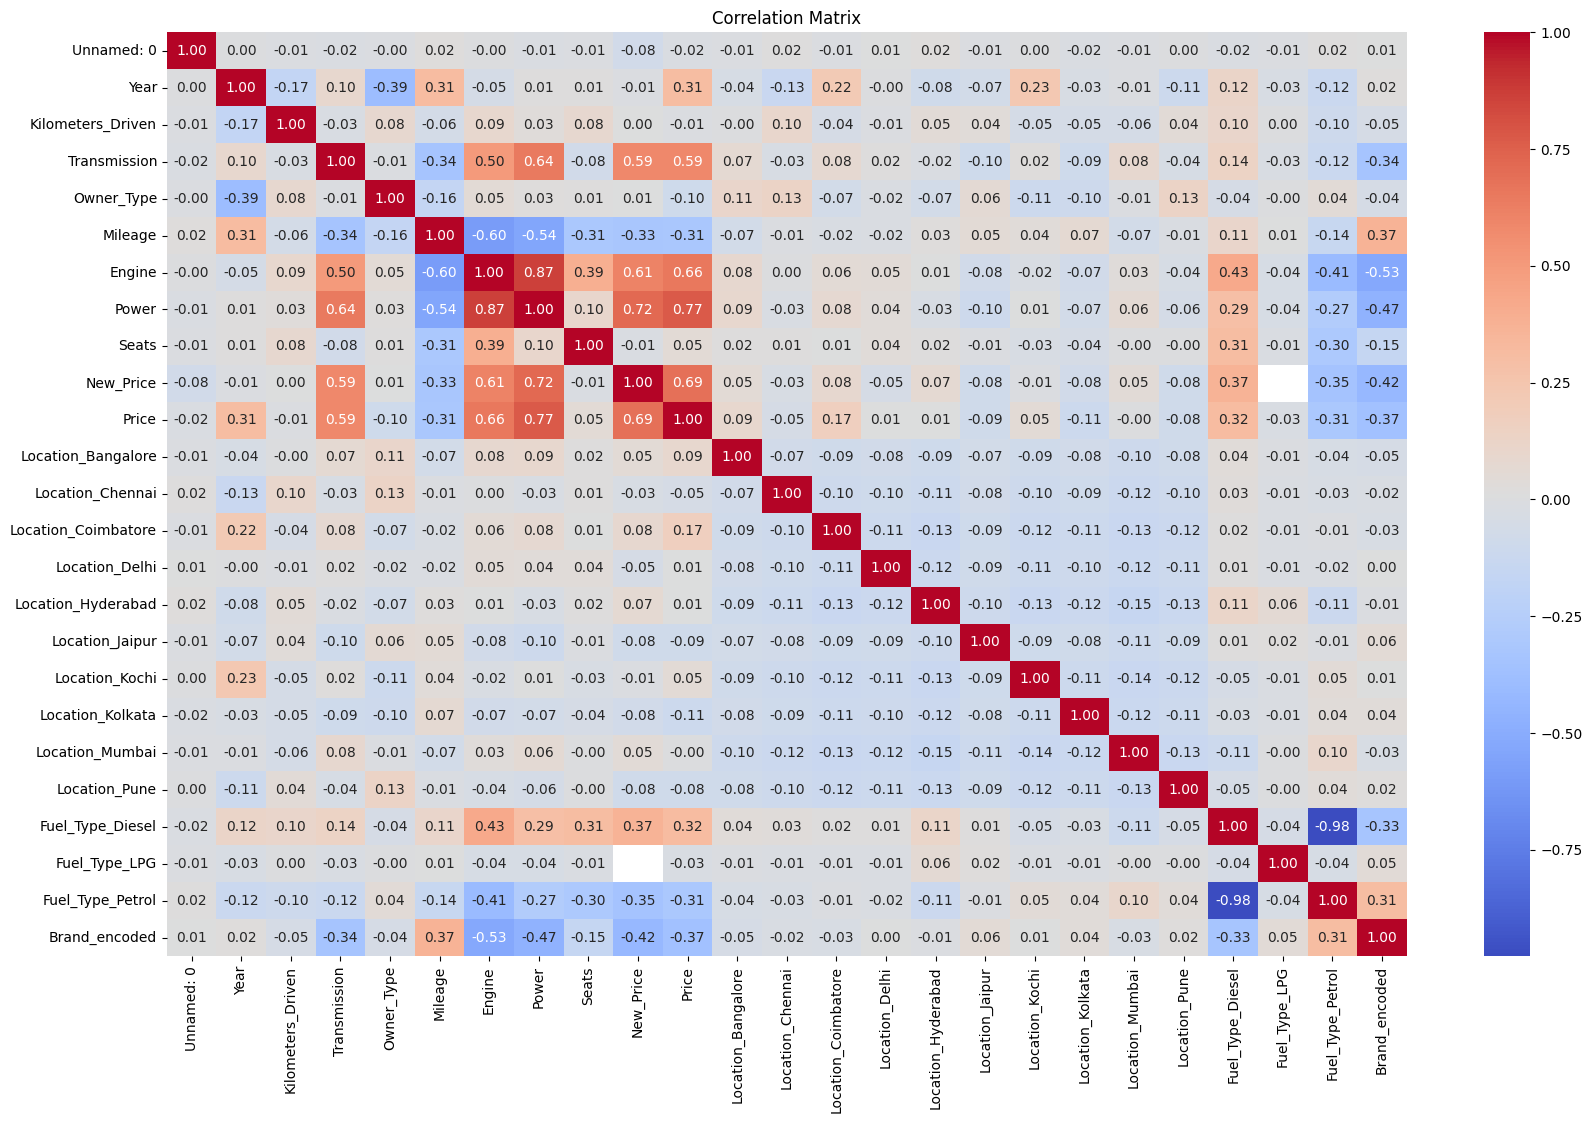

In [21]:
# Correlation matrix with only numerical features
correlation_matrix = df.corr(numeric_only=True)
print(correlation_matrix)
# Visualize it
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [22]:
corr_pairs = correlation_matrix.unstack()

# Take absolute value to consider both +ve and -ve correlations
abs_corr_pairs = corr_pairs.abs()

# Filter only strong correlations (excluding 1.0 which is correlation with itself)
strong_corr = abs_corr_pairs[(abs_corr_pairs > 0.7) & (abs_corr_pairs < 1.0)]

# Drop duplicate pairs (since correlation matrix is symmetric)
strong_corr = strong_corr.drop_duplicates().sort_values(ascending=False)

print(strong_corr)

Fuel_Type_Diesel  Fuel_Type_Petrol    0.978008
Engine            Power               0.866301
Power             Price               0.772843
                  New_Price           0.716737
dtype: float64


In [23]:
x= df[['Engine','Power','Mileage','Year']]
y=df['Price']

In [24]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

In [25]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(x_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
y_pred=model.predict(x_test)
y_pred

array([ 3.5454538,  3.9200664, 22.424398 , ...,  5.9579954,  6.020844 ,
        1.5449713], dtype=float32)

In [27]:
accuracy=r2_score(y_test,y_pred)
accuracy

0.8883706309141426

In [28]:
import joblib
joblib.dump(model, "car_price_predictor.pkl")


['car_price_predictor.pkl']

In [29]:
sample = x_test.iloc[0]
predicted = model.predict([sample])[0]
print(f"Predicted: ₹{predicted:.2f}L, Actual: ₹{y_test.iloc[0]:.2f}L")


Predicted: ₹3.55L, Actual: ₹3.60L


In [30]:
def get_valid_input(prompt, min_val=None, max_val=None, float_ok=False):
    while True:
        try:
            val = input(prompt)
            val = float(val) if float_ok else int(val)
            if min_val is not None and val < min_val:
                print(f"Value too low. Must be at least {min_val}.")
                continue
            if max_val is not None and val > max_val:
                print(f"Value too high. Must be at most {max_val}.")
                continue
            return val
        except ValueError:
            print("Invalid input. Please enter a valid number.")


In [32]:
def get_user_input():
    print("Please enter the following car details:\n")

    year = get_valid_input("Year of manufacture (1998–2019): ", 1998, 2019)
    mileage = get_valid_input("Mileage (kmpl or km/kg): ", 0, 33.4, float_ok=True)
    engine = get_valid_input("Engine capacity (in CC): ", 624, 5998)
    power = get_valid_input("Power (in BHP): ", 34.2, 560, float_ok=True)

    return {
        "Year": year,
        "Mileage": mileage,
        "Engine": engine,
        "Power": power
    }

input_data=get_user_input()

Please enter the following car details:

Year of manufacture (1998–2019): 2020
Value too high. Must be at most 2019.
Year of manufacture (1998–2019): 2019
Mileage (kmpl or km/kg): 20
Engine capacity (in CC): 5000
Power (in BHP): 500


In [33]:
import pandas as pd
import joblib

# Load trained model
model = joblib.load("car_price_predictor.pkl")

# Encode categorical features
def prepare_input(data):
    return pd.DataFrame([{


        "Engine": data["Engine"],
        "Power": data["Power"],"Mileage": data["Mileage"],"Year": data["Year"]
    }])
    return pd.DataFrame([processed])
input_df = prepare_input(input_data)
predicted_price = model.predict(input_df)[0]

print(f"\n💰 Estimated Car Price: ₹{predicted_price:.2f} Lakhs")

# Optional: Show a price range (±10%)
lower = predicted_price * 0.9
upper = predicted_price * 1.1
print(f"💡 Expected price range: ₹{lower:.2f}L – ₹{upper:.2f}L")



💰 Estimated Car Price: ₹76.35 Lakhs
💡 Expected price range: ₹68.72L – ₹83.99L



📊 Top 5 Features Influencing Price:
Feature  Importance
  Power    0.651755
   Year    0.213180
 Engine    0.097993
Mileage    0.037073


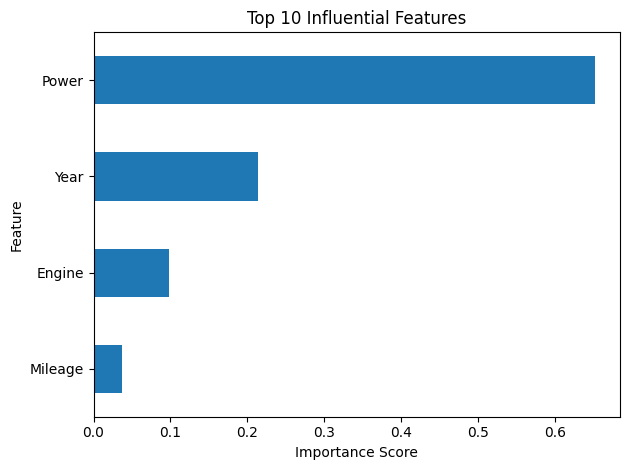

In [34]:
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
feature_names = input_df.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\n📊 Top 5 Features Influencing Price:")
print(importance_df.head(5).to_string(index=False))

# Optional: Plot
importance_df.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 10 Influential Features")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
